# Interest rate modeling using CIR - USDC vs WETH (AAVE V3)

### The strategy exemplified here is: lend USDC, borrow WETH

**Data: AAVE V3 from data/AAVE folder (aave_v3_usdc_eth.csv, aave_v3_weth_eth.csv)**

**The point here is that $\theta$ spread [$\theta$ from CIR (mean to which the interest rates revert to)] has to be greater than the volatility drag, unless our assets have really low or even negative correlation or low volatility. Otherwise we don't earn anything from the APY spread of the two tokens**

We could look into tokens with low correlation or less volatile


I'm looking into how we should deal with correlation and tail risk

I think we should also consider rebalancing, static portfolio might be unrealistic

In [12]:
#TODO model colateral factor, look into it, fit APR into h(t) or W(t) or do we assume static

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from log_health import HealthProcessParameters
from pathlib import Path
from IPython.display import display

In [13]:
def find_repo_root(start: Path = None) -> Path:
    p = Path.cwd() if start is None else Path(start)
    for d in [p] + list(p.parents):
        if (d / 'pyproject.toml').exists() or (d / '.git').exists():
            return d
    return p
repo_root = find_repo_root()
plots_dir = repo_root / 'results' / 'plots'

In [14]:
# Ensure Path.cwd() returns the repo root so later cells don't accidentally use src as root
_repo_root = find_repo_root()
Path.cwd = classmethod(lambda cls: _repo_root)
repo_root = _repo_root
plots_dir = repo_root / 'results' / 'plots'

**AAVE V3: Lender Variable APR (USDC) & Borrower Variable APR (WETH) Visualizations & descriptive stats**


Loaded aave_v3_usdc_eth.csv: (26208, 12)
Date range: 2023-01-27 08:00:00 to 2026-01-23 07:00:00


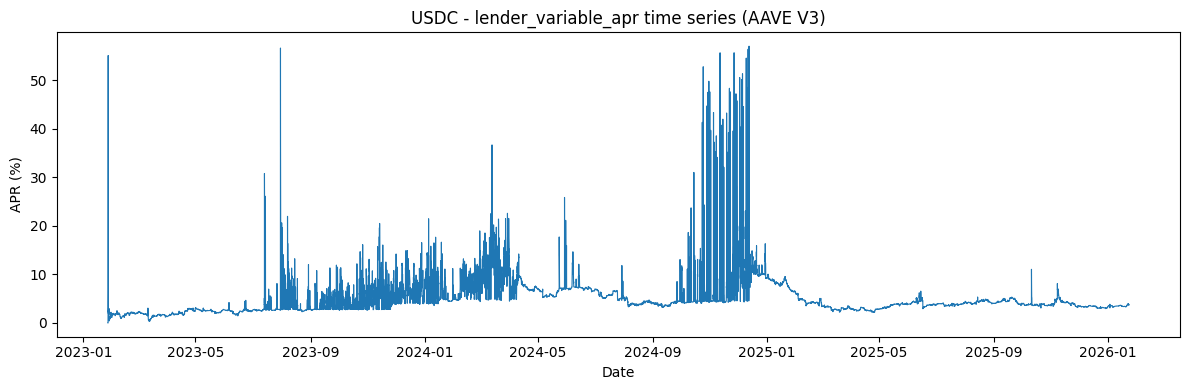


Summary for USDC (lender_variable_apr):
                       count      mean    median      std  min        max
lender_variable_apr  26207.0  4.976187  4.066623  3.33477  0.0  57.066085

Loaded aave_v3_weth_eth.csv: (26208, 12)
Date range: 2023-01-27 08:00:00 to 2026-01-23 07:00:00


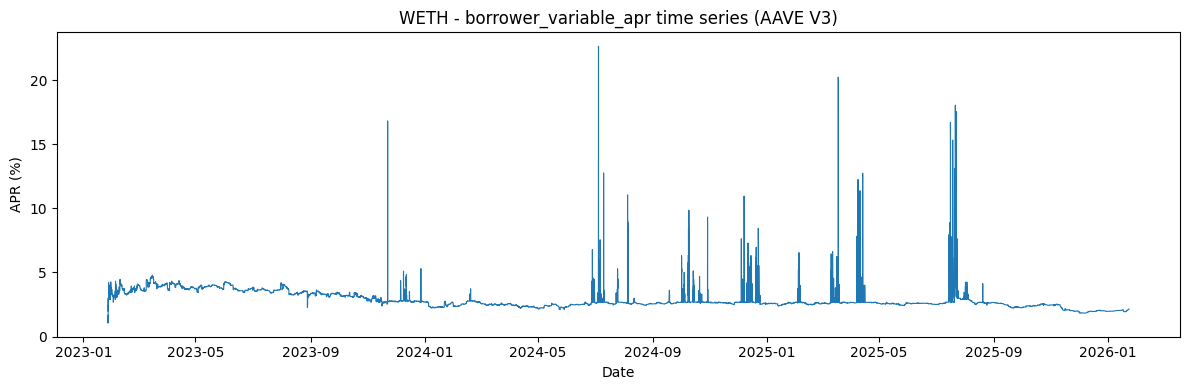


Summary for WETH (borrower_variable_apr):
                         count     mean    median       std       min  \
borrower_variable_apr  26207.0  2.86115  2.643411  0.746176  1.064176   

                             max  
borrower_variable_apr  22.643545  


In [15]:
# Load AAVE V3 data: USDC lender variable APR and WETH borrower variable APR
data_dir = repo_root / 'data' / 'AAVE'
files = {
    'USDC': ('aave_v3_usdc_eth.csv', 'lender_variable_apr'),
    'WETH': ('aave_v3_weth_eth.csv', 'borrower_variable_apr')
}

for asset, (fn, col) in files.items():
    fp = str(data_dir / fn)
    # First column is unnamed index, use index_col=0
    df = pd.read_csv(fp, index_col=0, parse_dates=True)
    # Parse the index as timestamps
    df.index = pd.to_datetime(df.index)
    print(f'\nLoaded {fn}:', df.shape)
    print(f'Date range: {df.index.min()} to {df.index.max()}')
    
    if col not in df.columns:
        print(f'{fn}: column {col} not found. Available columns: {df.columns.tolist()}')
        continue
    
    s = pd.to_numeric(df[col], errors='coerce')
    
    # Time series plot only
    fig, ax = plt.subplots(figsize=(12, 4))
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')
    
    ax.plot(df.index, s, lw=0.8)
    ax.set_title(f'{asset} - {col} time series (AAVE V3)')
    ax.set_xlabel('Date')
    ax.set_ylabel('APR (%)')
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    s_clean = s.dropna()
    summary = {
        col: {
            'count': int(s_clean.count()),
            'mean': float(s_clean.mean()),
            'median': float(s_clean.median()),
            'std': float(s_clean.std()),
            'min': float(s_clean.min()),
            'max': float(s_clean.max())
        }
    }
    print(f'\nSummary for {asset} ({col}):')
    print(pd.DataFrame(summary).T.round(6))

**CIR estimation for USDC lender rate and WETH borrower rate (AAVE V3, separate models)**

The cells below estimate CIR models separately for:
- USDC `lender_variable_apr` (supply/lending rate)
- WETH `borrower_variable_apr` (borrow rate)

Fitting both the Euler/GMM-style estimator and the exact MLE (non-central chi-square transition) implemented in `src/cir_model.py` for the full sample and for selected periods.

**Data source: AAVE V3 hourly data from data/AAVE folder**

In [16]:
import sys
repo_root = find_repo_root()
sys.path.insert(0, str(repo_root / 'src'))
# robustly import cir_model: reload if present, otherwise load from source file
import importlib, importlib.util
try:
    import cir_model
    importlib.reload(cir_model)
except Exception:
    spec = importlib.util.spec_from_file_location('cir_model', str(repo_root / 'src' / 'cir_model.py'))
    cir_model = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(cir_model)

In [17]:
repo_root = find_repo_root()
sys.path.insert(0, str(repo_root / 'src'))
# robust import of cir_model
try:
    import cir_model
    importlib.reload(cir_model)
except Exception:
    spec = importlib.util.spec_from_file_location('cir_model', str(repo_root / 'src' / 'cir_model.py'))
    cir_model = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(cir_model)

# Load AAVE V3 data files
fp_usdc = repo_root / 'data' / 'AAVE' / 'aave_v3_usdc_eth.csv'
fp_weth = repo_root / 'data' / 'AAVE' / 'aave_v3_weth_eth.csv'
out_dir = repo_root / 'results'
out_dir.mkdir(parents=True, exist_ok=True)
rows = []

if not fp_usdc.exists() or not fp_weth.exists():
    print('Missing input CSVs at', fp_usdc, fp_weth)
else:
    # Load data - first column is unnamed index
    df_usdc = pd.read_csv(fp_usdc, index_col=0, parse_dates=True)
    df_usdc.index = pd.to_datetime(df_usdc.index)
    
    df_weth = pd.read_csv(fp_weth, index_col=0, parse_dates=True)
    df_weth.index = pd.to_datetime(df_weth.index)
    
    if 'lender_variable_apr' not in df_usdc.columns or 'borrower_variable_apr' not in df_weth.columns:
        print('Required columns missing in inputs')
        print(f'USDC columns: {df_usdc.columns.tolist()}')
        print(f'WETH columns: {df_weth.columns.tolist()}')
    else:
        series_defs = {
            'USDC_lend': (df_usdc['lender_variable_apr'], 'USDC'),
            'WETH_borrow': (df_weth['borrower_variable_apr'], 'WETH')
        }
        
        def infer_dt(idx):
            """Infer time step in years from datetime index (hourly data)."""
            if not isinstance(idx, pd.DatetimeIndex) or len(idx) < 2:
                return 1.0 / (365.0 * 24)  # hourly default
            median_sec = idx.to_series().diff().dt.total_seconds().median()
            if pd.isna(median_sec) or median_sec <= 0:
                return 1.0 / (365.0 * 24)
            return float(median_sec) / (3600 * 24 * 365)
        
        for name, (ser, asset_label) in series_defs.items():
            s = pd.to_numeric(ser, errors='coerce').dropna()
            if s.empty:
                rows.append({'series': name, 'asset': asset_label, 'period': 'FULL', 'n': 0})
                continue
            dt = infer_dt(s.index)
            try:
                efit = cir_model.fit_cir_euler(s.values, dt)
            except Exception as ex:
                efit = None
                print('Euler fit error', name, ex)
            try:
                mfit = cir_model.fit_cir_mle(s.values, dt)
            except Exception as ex:
                mfit = None
                print('MLE fit error', name, ex)
            row = dict(series=name, asset=asset_label, period='FULL', n=len(s), dt=dt)
            if efit:
                row.update({'e_kappa': efit.get('kappa'), 'e_theta': efit.get('theta'), 'e_sigma': efit.get('sigma')})
            if mfit:
                row.update({'m_kappa': mfit.get('kappa'), 'm_theta': mfit.get('theta'), 'm_sigma': mfit.get('sigma'), 'm_success': mfit.get('success')})
            rows.append(row)
        
        out_df = pd.DataFrame(rows)
        out_fp = out_dir / 'cir_usdc_weth_aave_v3.csv'
        out_df.to_csv(out_fp, index=False)
        print(f'Saved CIR results to {out_fp}')
        display(out_df.round(6))

Saved CIR results to /Users/tedig/Defi_interestRate/results/cir_usdc_weth_aave_v3.csv


,series,asset,period,n,dt,e_kappa,e_theta,e_sigma,m_kappa,m_theta,m_sigma,m_success
0,USDC_lend,USDC,FULL,26207,0.000114,2088.663589,4.976829,90.668636,18.451803,2.0,10.0,True
1,WETH_borrow,WETH,FULL,26207,0.000114,1399.342281,2.861435,22.378199,113.795301,2.0,10.0,True


In [18]:
# Volatility Drag: σ_h² = var(ln(USDC) - ln(WETH))
# Compute volatility from actual price data for both USDC and WETH

repo_root = find_repo_root()

print("Computing volatility drag for USDC (lend) / WETH (borrow) strategy...")
print("="*60)

# Load both USDC and WETH price data from AAVE files
fp_usdc = repo_root / 'data' / 'AAVE' / 'aave_v3_usdc_eth.csv'
fp_weth = repo_root / 'data' / 'AAVE' / 'aave_v3_weth_eth.csv'

hours_per_year = 365.25 * 24
q_low, q_high = 0.01, 0.99

sigma_usdc = None
sigma_weth = None
usdc_returns = None
weth_returns = None

# Load USDC price data
if fp_usdc.exists():
    df_usdc = pd.read_csv(fp_usdc, index_col=0, parse_dates=True)
    df_usdc.index = pd.to_datetime(df_usdc.index)
    
    if 'close' in df_usdc.columns:
        prices_usdc = pd.to_numeric(df_usdc['close'], errors='coerce').dropna()
        prices_usdc = prices_usdc[prices_usdc > 0]
        
        # Calculate log returns
        log_returns_usdc = np.log(prices_usdc / prices_usdc.shift(1)).dropna()
        
        # Filter out extreme returns
        low = log_returns_usdc.quantile(q_low)
        high = log_returns_usdc.quantile(q_high)
        usdc_returns = log_returns_usdc[(log_returns_usdc >= low) & (log_returns_usdc <= high)]
        
        # Annualized volatility
        sigma_usdc_hourly = float(usdc_returns.std())
        sigma_usdc = sigma_usdc_hourly * np.sqrt(hours_per_year)
        print(f"\nUSDC volatility (from {len(usdc_returns)} hourly returns):")
        print(f"  σ_USDC (hourly) = {sigma_usdc_hourly:.8f}")
        print(f"  σ_USDC (annual) = {sigma_usdc:.6f}")
    else:
        print("Error: 'close' column not found in USDC data")
else:
    print(f"Error: USDC data not found at {fp_usdc}")

# Load WETH price data
if fp_weth.exists():
    df_weth = pd.read_csv(fp_weth, index_col=0, parse_dates=True)
    df_weth.index = pd.to_datetime(df_weth.index)
    
    if 'close' in df_weth.columns:
        prices_weth = pd.to_numeric(df_weth['close'], errors='coerce').dropna()
        prices_weth = prices_weth[prices_weth > 0]
        
        # Calculate log returns
        log_returns_weth = np.log(prices_weth / prices_weth.shift(1)).dropna()
        
        # Filter out extreme returns
        low = log_returns_weth.quantile(q_low)
        high = log_returns_weth.quantile(q_high)
        weth_returns = log_returns_weth[(log_returns_weth >= low) & (log_returns_weth <= high)]
        
        # Annualized volatility
        sigma_weth_hourly = float(weth_returns.std())
        sigma_weth = sigma_weth_hourly * np.sqrt(hours_per_year)
        print(f"\nWETH volatility (from {len(weth_returns)} hourly returns):")
        print(f"  σ_WETH (hourly) = {sigma_weth_hourly:.8f}")
        print(f"  σ_WETH (annual) = {sigma_weth:.6f}")
    else:
        print("Error: 'close' column not found in WETH data")
else:
    print(f"Error: WETH data not found at {fp_weth}")

# Compute correlation and volatility drag
if sigma_usdc is not None and sigma_weth is not None and usdc_returns is not None and weth_returns is not None:
    # Align returns by index to compute correlation
    aligned = pd.concat([usdc_returns.rename('USDC'), weth_returns.rename('WETH')], axis=1).dropna()
    rho = float(aligned['USDC'].corr(aligned['WETH']))
    
    print(f"\nCorrelation (from {len(aligned)} aligned returns):")
    print(f"  ρ (USDC, WETH) = {rho:.6f}")
    
    # Volatility drag: σ_h² = σ_WETH² + σ_USDC² - 2ρσ_WETH σ_USDC
    sigma_h2 = sigma_weth**2 + sigma_usdc**2 - 2.0 * rho * sigma_weth * sigma_usdc
    
    print(f"\nVolatility Drag (σ_h²):")
    print(f"  σ_h² = σ_WETH² + σ_USDC² - 2ρσ_WETH σ_USDC")
    print(f"  σ_h² = {sigma_weth:.6f}² + {sigma_usdc:.6f}² - 2×{rho:.6f}×{sigma_weth:.6f}×{sigma_usdc:.6f}")
    print(f"  σ_h² = {sigma_h2:.6f}")
else:
    print("\nError: Could not compute volatility drag - missing data")
    sigma_h2 = float('nan')

# Calculate μ_h using θ_USDC - θ_WETH as the drift component from interest rates
print("\n" + "="*60)
print("DRIFT CALCULATION: μ_h = (θ_USDC - θ_WETH) - 0.5 * σ_h²")
print("="*60)

if not np.isnan(sigma_h2):
    # Load USDC and WETH CIR results
    separate_fp = repo_root / 'results' / 'cir_usdc_weth_aave_v3.csv'
    if separate_fp.exists():
        df_sep = pd.read_csv(separate_fp)
        
        print(f"\nUsing σ_h² = {sigma_h2:.6f}")
        print(f"Half variance term: 0.5 * σ_h² = {0.5 * sigma_h2:.6f}")
        
        # Get USDC theta (FULL period only)
        usdc_row = df_sep[df_sep['asset'] == 'USDC']
        weth_row = df_sep[df_sep['asset'] == 'WETH']
        
        theta_usdc = None
        theta_weth = None
        usdc_method = None
        weth_method = None
        
        if not usdc_row.empty:
            row = usdc_row.iloc[0]
            if 'm_theta' in row.index and pd.notna(row['m_theta']) and row.get('m_success', True):
                theta_usdc = row['m_theta']
                usdc_method = "MLE"
            elif 'e_theta' in row.index and pd.notna(row['e_theta']):
                theta_usdc = row['e_theta']
                usdc_method = "Euler"
                
        if not weth_row.empty:
            row = weth_row.iloc[0]
            if 'm_theta' in row.index and pd.notna(row['m_theta']) and row.get('m_success', True):
                theta_weth = row['m_theta']
                weth_method = "MLE"
            elif 'e_theta' in row.index and pd.notna(row['e_theta']):
                theta_weth = row['e_theta']
                weth_method = "Euler"
        
        if theta_usdc is not None and theta_weth is not None:
            theta_spread = theta_usdc - theta_weth
            mu_h = theta_spread - 0.5 * sigma_h2
            print(f"\nResults for full period:")
            print(f"  θ_USDC = {theta_usdc:.6f} ({usdc_method})")
            print(f"  θ_WETH = {theta_weth:.6f} ({weth_method})")
            print(f"  θ_spread (USDC - WETH) = {theta_spread:.6f}")
            print(f"  μ_h = θ_spread - 0.5×σ_h² = {theta_spread:.6f} - {0.5 * sigma_h2:.6f} = {mu_h:.6f}")
        else:
            print(f"Missing theta estimates (USDC: {theta_usdc}, WETH: {theta_weth})")
                
    else:
        print(f"CIR results not found at {separate_fp}")
        print("Run the CIR fitting cell first to generate cir_usdc_weth_aave_v3.csv")
else:
    print("Cannot calculate μ_h: σ_h² is not available")

Computing volatility drag for USDC (lend) / WETH (borrow) strategy...

USDC volatility (from 25680 hourly returns):
  σ_USDC (hourly) = 0.00000480
  σ_USDC (annual) = 0.000450

WETH volatility (from 25680 hourly returns):
  σ_WETH (hourly) = 0.00520275
  σ_WETH (annual) = 0.487118

Correlation (from 25166 aligned returns):
  ρ (USDC, WETH) = 0.003049

Volatility Drag (σ_h²):
  σ_h² = σ_WETH² + σ_USDC² - 2ρσ_WETH σ_USDC
  σ_h² = 0.487118² + 0.000450² - 2×0.003049×0.487118×0.000450
  σ_h² = 0.237283

DRIFT CALCULATION: μ_h = (θ_USDC - θ_WETH) - 0.5 * σ_h²

Using σ_h² = 0.237283
Half variance term: 0.5 * σ_h² = 0.118641

Results for full period:
  θ_USDC = 2.000000 (MLE)
  θ_WETH = 2.000000 (MLE)
  θ_spread (USDC - WETH) = 0.000000
  μ_h = θ_spread - 0.5×σ_h² = 0.000000 - 0.118641 = -0.118641


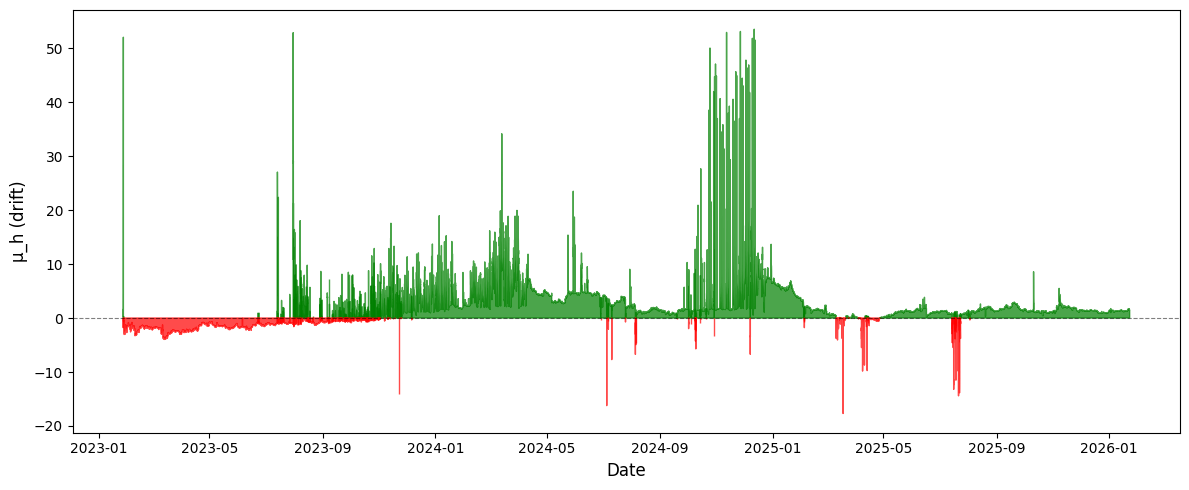


Drift (μ_h) Statistics:
  Mean       = 1.996396
  Median     = 1.400119
  Std        = 3.570001
  % Positive = 75.01%

Volatility drag: 0.5 × σ_h² = 0.118641


In [19]:
# Plot μ_h (drift) for entire period - green above 0, red below 0

# Create aligned rates DataFrame from USDC and WETH rate data
usdc_rates = pd.to_numeric(df_usdc['lender_variable_apr'], errors='coerce').dropna()
weth_rates = pd.to_numeric(df_weth['borrower_variable_apr'], errors='coerce').dropna()
aligned_rates = pd.concat([usdc_rates.rename('usdc_rate'), weth_rates.rename('weth_rate')], axis=1).dropna()

# Compute theta spread and drift from aligned rates
theta_spread_ts = aligned_rates['usdc_rate'] - aligned_rates['weth_rate']
drift_ts = theta_spread_ts - 0.5 * sigma_h2

fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor('none')
ax.set_facecolor('none')

# Plot positive values in green
pos_mask = drift_ts.values >= 0
neg_mask = drift_ts.values < 0

ax.fill_between(drift_ts.index, drift_ts.values, 0, 
                where=pos_mask, color='green', alpha=0.7)
ax.fill_between(drift_ts.index, drift_ts.values, 0, 
                where=neg_mask, color='red', alpha=0.7)

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('μ_h (drift)', fontsize=12)
ax.grid(False)
plt.tight_layout()

outp = repo_root / 'results' / 'plots' / 'drift_time_series_colored.png'
outp.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(outp, bbox_inches='tight', transparent=True)
plt.show()

# Summary statistics
print(f"\nDrift (μ_h) Statistics:")
print(f"  Mean       = {drift_ts.mean():.6f}")
print(f"  Median     = {drift_ts.median():.6f}")
print(f"  Std        = {drift_ts.std():.6f}")
print(f"  % Positive = {(drift_ts > 0).mean() * 100:.2f}%")
print(f"\nVolatility drag: 0.5 × σ_h² = {0.5 * sigma_h2:.6f}")

## CIR Model with Jumps (JCIR)

The standard CIR model may not capture sudden spikes or drops in interest rates. We extend the model to include jumps:

$$dX_t = \kappa(\theta - X_t)dt + \sigma\sqrt{X_t}dW_t + J_t dN_t$$

Where:
- $N_t$ is a Poisson process with intensity $\lambda$ (jump arrival rate)
- $J_t$ is the jump size, typically exponentially distributed with mean $\mu_J$

This Jump-CIR (JCIR) model better captures:
- Sudden spikes in borrowing rates during high demand
- Flash crashes in lending rates
- Market stress events

In [20]:
# JCIR Model Implementation: CIR with Jumps
# dX_t = kappa*(theta - X_t)*dt + sigma*sqrt(X_t)*dW_t + J_t*dN_t

import numpy as np
from typing import Optional, Dict, Tuple
from scipy.optimize import minimize
from scipy.stats import poisson, expon

def simulate_jcir_euler(
    x0: float, 
    kappa: float, 
    theta: float, 
    sigma: float,
    lambda_jump: float,  # Poisson intensity (jumps per year)
    mu_jump: float,      # Mean jump size (exponential)
    dt: float, 
    n_steps: int, 
    rng: Optional[np.random.Generator] = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate Jump-CIR via Euler-Maruyama with Poisson jumps.
    
    Jump sizes are exponentially distributed (positive jumps only for rate increases).
    For negative jumps, we use a mixture or signed exponential.
    
    Returns:
        xs: array of process values (length n_steps+1)
        jump_times: boolean array indicating when jumps occurred
    """
    if rng is None:
        rng = np.random.default_rng()
    
    xs = np.empty(n_steps + 1, dtype=float)
    jump_occurred = np.zeros(n_steps + 1, dtype=bool)
    xs[0] = float(x0)
    
    for i in range(n_steps):
        xi = xs[i]
        
        # Standard CIR diffusion
        dW = rng.normal(loc=0.0, scale=np.sqrt(dt))
        dx = kappa * (theta - xi) * dt + sigma * np.sqrt(max(xi, 0.0)) * dW
        
        # Poisson jump component
        # Probability of at least one jump in interval dt
        prob_jump = 1 - np.exp(-lambda_jump * dt)
        if rng.random() < prob_jump:
            # Jump size: exponentially distributed, can be positive or negative
            # Use sign with 50-50 probability for symmetric jumps
            jump_sign = rng.choice([-1, 1])
            jump_size = jump_sign * rng.exponential(scale=mu_jump)
            dx += jump_size
            jump_occurred[i + 1] = True
        
        xn = xi + dx
        # Enforce non-negativity
        xs[i + 1] = max(xn, 0.0)
    
    return xs, jump_occurred


def detect_jumps(x: np.ndarray, threshold_std: float = 3.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Detect jumps in observed data using a threshold-based method.
    
    Returns:
        jump_indices: indices where jumps were detected
        jump_sizes: estimated jump sizes
    """
    dx = np.diff(x)
    std_dx = np.std(dx)
    mean_dx = np.mean(dx)
    
    # Detect jumps as changes exceeding threshold
    threshold = threshold_std * std_dx
    jump_mask = np.abs(dx - mean_dx) > threshold
    jump_indices = np.where(jump_mask)[0] + 1
    jump_sizes = dx[jump_mask]
    
    return jump_indices, jump_sizes


def fit_jcir_euler(
    x: np.ndarray, 
    dt: float, 
    threshold_std: float = 3.0
) -> Dict[str, float]:
    """
    Fit JCIR parameters from observations using two-step approach:
    1. Detect and remove jumps
    2. Fit standard CIR to filtered series
    3. Estimate jump parameters from detected jumps
    
    Returns dict with CIR params + jump params: 
    {'kappa', 'theta', 'sigma', 'lambda_jump', 'mu_jump', 'n_jumps'}
    """
    x = np.asarray(x, dtype=float)
    if x.ndim != 1 or x.size < 3:
        raise ValueError("x must be a 1-D array with at least 3 observations")
    
    # Step 1: Detect jumps
    jump_indices, jump_sizes = detect_jumps(x, threshold_std)
    n_jumps = len(jump_indices)
    
    # Step 2: Create filtered series (remove jump contributions)
    dx = np.diff(x)
    dx_filtered = dx.copy()
    
    if n_jumps > 0:
        # Remove detected jumps from differences
        for idx in jump_indices - 1:  # adjust for diff indexing
            if 0 <= idx < len(dx_filtered):
                # Replace jump with median change
                dx_filtered[idx] = np.median(dx)
    
    # Reconstruct filtered series
    x_filtered = np.zeros_like(x)
    x_filtered[0] = x[0]
    x_filtered[1:] = x[0] + np.cumsum(dx_filtered)
    x_filtered = np.maximum(x_filtered, 0)  # ensure non-negative
    
    # Step 3: Fit CIR to filtered series
    x_lag = x_filtered[:-1]
    dx_f = x_filtered[1:] - x_lag
    
    # Design matrix [1, x_lag]
    A = np.vstack([np.ones_like(x_lag), x_lag]).T
    coeffs, *_ = np.linalg.lstsq(A, dx_f, rcond=None)
    a_hat, b_hat = coeffs
    
    # Translate to CIR parameters
    kappa_hat = -b_hat / dt
    if abs(b_hat) < 1e-12:
        kappa_hat = 1.0  # fallback
    theta_hat = a_hat / (kappa_hat * dt) if kappa_hat > 0 else np.mean(x)
    
    # Estimate sigma from residuals
    resid = dx_f - (a_hat + b_hat * x_lag)
    denom = dt * np.sum(np.where(x_lag > 0, x_lag, 1e-8))
    sigma2_hat = np.sum(resid ** 2) / denom if denom > 0 else 0
    sigma_hat = float(np.sqrt(max(0.0, sigma2_hat)))
    
    # Step 4: Estimate jump parameters
    T = len(x) * dt  # Total time span
    lambda_hat = n_jumps / T if T > 0 else 0
    mu_jump_hat = np.mean(np.abs(jump_sizes)) if n_jumps > 0 else 0
    
    return {
        "kappa": float(kappa_hat),
        "theta": float(theta_hat),
        "sigma": float(sigma_hat),
        "lambda_jump": float(lambda_hat),
        "mu_jump": float(mu_jump_hat),
        "n_jumps": int(n_jumps),
        "jump_indices": jump_indices.tolist(),
        "jump_sizes": jump_sizes.tolist()
    }

print("JCIR (Jump-CIR) model functions defined successfully.")

JCIR (Jump-CIR) model functions defined successfully.


In [21]:
# Fit JCIR model to USDC and WETH rates (AAVE V3)

repo_root = find_repo_root()
jcir_rows = []

# Load AAVE V3 data files
fp_usdc = repo_root / 'data' / 'AAVE' / 'aave_v3_usdc_eth.csv'
fp_weth = repo_root / 'data' / 'AAVE' / 'aave_v3_weth_eth.csv'

if fp_usdc.exists() and fp_weth.exists():
    # Load data
    df_usdc = pd.read_csv(fp_usdc, index_col=0, parse_dates=True)
    df_usdc.index = pd.to_datetime(df_usdc.index)
    
    df_weth = pd.read_csv(fp_weth, index_col=0, parse_dates=True)
    df_weth.index = pd.to_datetime(df_weth.index)
    
    series_defs = {
        'USDC_lend': (df_usdc['lender_variable_apr'], 'USDC'),
        'WETH_borrow': (df_weth['borrower_variable_apr'], 'WETH')
    }
    
    def infer_dt(idx):
        """Infer time step in years from datetime index (hourly data)."""
        if not isinstance(idx, pd.DatetimeIndex) or len(idx) < 2:
            return 1.0 / (365.0 * 24)
        median_sec = idx.to_series().diff().dt.total_seconds().median()
        if pd.isna(median_sec) or median_sec <= 0:
            return 1.0 / (365.0 * 24)
        return float(median_sec) / (3600 * 24 * 365)
    
    print("="*70)
    print("JCIR (Jump-CIR) Model Estimation Results")
    print("="*70)
    
    for name, (ser, asset_label) in series_defs.items():
        s = pd.to_numeric(ser, errors='coerce').dropna()
        if s.empty:
            continue
            
        dt = infer_dt(s.index)
        
        try:
            jcir_fit = fit_jcir_euler(s.values, dt, threshold_std=3.0)
            
            print(f"\n{asset_label} ({name}):")
            print(f"  CIR Parameters:")
            print(f"    κ (mean reversion) = {jcir_fit['kappa']:.6f}")
            print(f"    θ (long-run mean)  = {jcir_fit['theta']:.6f}")
            print(f"    σ (volatility)     = {jcir_fit['sigma']:.6f}")
            print(f"  Jump Parameters:")
            print(f"    λ (intensity/yr)   = {jcir_fit['lambda_jump']:.4f}")
            print(f"    μ_J (mean size)    = {jcir_fit['mu_jump']:.6f}")
            print(f"    # jumps detected   = {jcir_fit['n_jumps']}")
            
            row = {
                'series': name,
                'asset': asset_label,
                'n_obs': len(s),
                'dt': dt,
                'kappa': jcir_fit['kappa'],
                'theta': jcir_fit['theta'],
                'sigma': jcir_fit['sigma'],
                'lambda_jump': jcir_fit['lambda_jump'],
                'mu_jump': jcir_fit['mu_jump'],
                'n_jumps': jcir_fit['n_jumps']
            }
            jcir_rows.append(row)
            
        except Exception as ex:
            print(f"  Error fitting {name}: {ex}")
    
    # Save JCIR results
    jcir_df = pd.DataFrame(jcir_rows)
    out_fp = repo_root / 'results' / 'jcir_usdc_weth_aave_v3.csv'
    jcir_df.to_csv(out_fp, index=False)
    print(f"\n\nSaved JCIR results to {out_fp}")
    display(jcir_df.round(6))
else:
    print("Missing input data files")

JCIR (Jump-CIR) Model Estimation Results

USDC (USDC_lend):
  CIR Parameters:
    κ (mean reversion) = 6.910955
    θ (long-run mean)  = 1.006109
    σ (volatility)     = 8.504498
  Jump Parameters:
    λ (intensity/yr)   = 68.1894
    μ_J (mean size)    = 20.576605
    # jumps detected   = 204

WETH (WETH_borrow):
  CIR Parameters:
    κ (mean reversion) = 4.033759
    θ (long-run mean)  = 1.528912
    σ (volatility)     = 3.520174
  Jump Parameters:
    λ (intensity/yr)   = 70.1950
    μ_J (mean size)    = 3.422368
    # jumps detected   = 210


Saved JCIR results to /Users/tedig/Defi_interestRate/results/jcir_usdc_weth_aave_v3.csv


,series,asset,n_obs,dt,kappa,theta,sigma,lambda_jump,mu_jump,n_jumps
0,USDC_lend,USDC,26207,0.000114,6.910955,1.006109,8.504498,68.189415,20.576605,204
1,WETH_borrow,WETH,26207,0.000114,4.033759,1.528912,3.520174,70.194986,3.422368,210


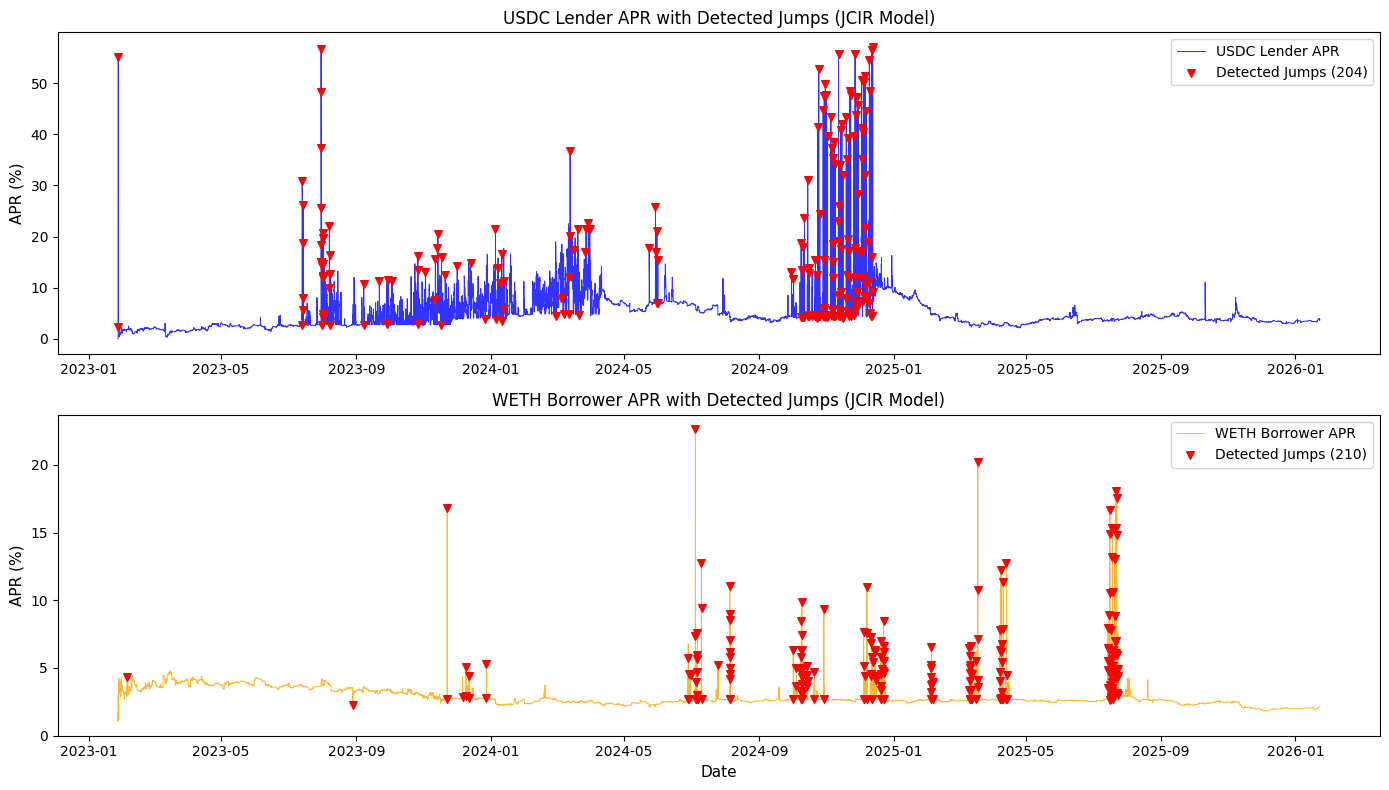

Saved jump detection plot to /Users/tedig/Defi_interestRate/results/plots/jcir_detected_jumps.png


In [22]:
# Visualize detected jumps in the interest rate series

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
fig.patch.set_facecolor('none')

series_defs_viz = {
    'USDC_lend': (df_usdc['lender_variable_apr'], 'USDC Lender APR', 'blue'),
    'WETH_borrow': (df_weth['borrower_variable_apr'], 'WETH Borrower APR', 'orange')
}

for ax, (name, (ser, label, color)) in zip(axes, series_defs_viz.items()):
    s = pd.to_numeric(ser, errors='coerce').dropna()
    dt = infer_dt(s.index)
    
    # Get jump info
    jcir_fit = fit_jcir_euler(s.values, dt, threshold_std=3.0)
    jump_indices = jcir_fit['jump_indices']
    
    ax.set_facecolor('none')
    ax.plot(s.index, s.values, lw=0.7, color=color, alpha=0.8, label=label)
    
    # Mark detected jumps
    if len(jump_indices) > 0:
        jump_times = s.index[jump_indices]
        jump_values = s.values[jump_indices]
        ax.scatter(jump_times, jump_values, color='red', s=30, zorder=5, 
                   label=f'Detected Jumps ({len(jump_indices)})', marker='v')
    
    ax.set_ylabel('APR (%)', fontsize=11)
    ax.set_title(f'{label} with Detected Jumps (JCIR Model)', fontsize=12)
    ax.legend(loc='upper right')
    ax.grid(False)

axes[-1].set_xlabel('Date', fontsize=11)
plt.tight_layout()

outp = repo_root / 'results' / 'plots' / 'jcir_detected_jumps.png'
outp.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(outp, bbox_inches='tight', transparent=True, dpi=150)
plt.show()

print(f"Saved jump detection plot to {outp}")

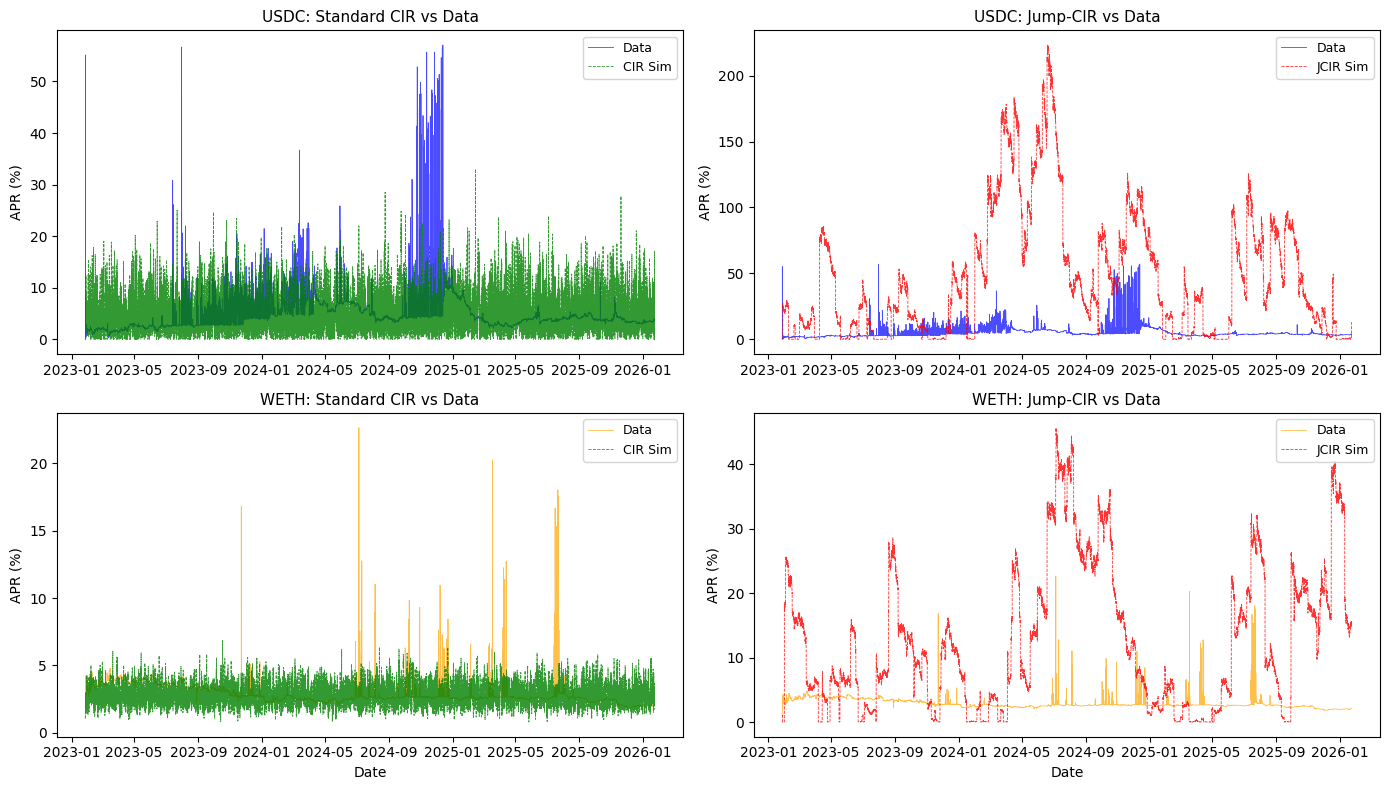

Saved comparison plot to /Users/tedig/Defi_interestRate/results/plots/cir_vs_jcir_comparison.png


In [23]:
# Compare CIR vs JCIR simulated paths

# Get fitted parameters for both models
usdc_ser = pd.to_numeric(df_usdc['lender_variable_apr'], errors='coerce').dropna()
weth_ser = pd.to_numeric(df_weth['borrower_variable_apr'], errors='coerce').dropna()
dt_usdc = infer_dt(usdc_ser.index)
dt_weth = infer_dt(weth_ser.index)

# Fit both models
cir_usdc = cir_model.fit_cir_euler(usdc_ser.values, dt_usdc)
jcir_usdc = fit_jcir_euler(usdc_ser.values, dt_usdc, threshold_std=3.0)

cir_weth = cir_model.fit_cir_euler(weth_ser.values, dt_weth)
jcir_weth = fit_jcir_euler(weth_ser.values, dt_weth, threshold_std=3.0)

# Simulation parameters
n_sim = min(len(usdc_ser), len(weth_ser)) - 1
rng = np.random.default_rng(42)

# Simulate paths
cir_usdc_sim = cir_model.simulate_cir_euler(
    usdc_ser.values[0], cir_usdc['kappa'], cir_usdc['theta'], cir_usdc['sigma'],
    dt_usdc, n_sim, rng=np.random.default_rng(42)
)
jcir_usdc_sim, _ = simulate_jcir_euler(
    usdc_ser.values[0], jcir_usdc['kappa'], jcir_usdc['theta'], jcir_usdc['sigma'],
    jcir_usdc['lambda_jump'], jcir_usdc['mu_jump'],
    dt_usdc, n_sim, rng=np.random.default_rng(42)
)

cir_weth_sim = cir_model.simulate_cir_euler(
    weth_ser.values[0], cir_weth['kappa'], cir_weth['theta'], cir_weth['sigma'],
    dt_weth, n_sim, rng=np.random.default_rng(43)
)
jcir_weth_sim, _ = simulate_jcir_euler(
    weth_ser.values[0], jcir_weth['kappa'], jcir_weth['theta'], jcir_weth['sigma'],
    jcir_weth['lambda_jump'], jcir_weth['mu_jump'],
    dt_weth, n_sim, rng=np.random.default_rng(43)
)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.patch.set_facecolor('none')

# USDC: CIR vs Data
ax = axes[0, 0]
ax.set_facecolor('none')
ax.plot(usdc_ser.index[:n_sim+1], usdc_ser.values[:n_sim+1], 'b-', lw=0.6, alpha=0.7, label='Data')
ax.plot(usdc_ser.index[:n_sim+1], cir_usdc_sim, 'g--', lw=0.6, alpha=0.8, label='CIR Sim')
ax.set_title('USDC: Standard CIR vs Data', fontsize=11)
ax.set_ylabel('APR (%)')
ax.legend(loc='upper right', fontsize=9)
ax.grid(False)

# USDC: JCIR vs Data
ax = axes[0, 1]
ax.set_facecolor('none')
ax.plot(usdc_ser.index[:n_sim+1], usdc_ser.values[:n_sim+1], 'b-', lw=0.6, alpha=0.7, label='Data')
ax.plot(usdc_ser.index[:n_sim+1], jcir_usdc_sim, 'r--', lw=0.6, alpha=0.8, label='JCIR Sim')
ax.set_title('USDC: Jump-CIR vs Data', fontsize=11)
ax.set_ylabel('APR (%)')
ax.legend(loc='upper right', fontsize=9)
ax.grid(False)

# WETH: CIR vs Data
ax = axes[1, 0]
ax.set_facecolor('none')
ax.plot(weth_ser.index[:n_sim+1], weth_ser.values[:n_sim+1], color='orange', lw=0.6, alpha=0.7, label='Data')
ax.plot(weth_ser.index[:n_sim+1], cir_weth_sim, 'g--', lw=0.6, alpha=0.8, label='CIR Sim')
ax.set_title('WETH: Standard CIR vs Data', fontsize=11)
ax.set_xlabel('Date')
ax.set_ylabel('APR (%)')
ax.legend(loc='upper right', fontsize=9)
ax.grid(False)

# WETH: JCIR vs Data
ax = axes[1, 1]
ax.set_facecolor('none')
ax.plot(weth_ser.index[:n_sim+1], weth_ser.values[:n_sim+1], color='orange', lw=0.6, alpha=0.7, label='Data')
ax.plot(weth_ser.index[:n_sim+1], jcir_weth_sim, 'r--', lw=0.6, alpha=0.8, label='JCIR Sim')
ax.set_title('WETH: Jump-CIR vs Data', fontsize=11)
ax.set_xlabel('Date')
ax.set_ylabel('APR (%)')
ax.legend(loc='upper right', fontsize=9)
ax.grid(False)

plt.tight_layout()

outp = repo_root / 'results' / 'plots' / 'cir_vs_jcir_comparison.png'
plt.savefig(outp, bbox_inches='tight', transparent=True, dpi=150)
plt.show()

print(f"Saved comparison plot to {outp}")

In [24]:
# Compute drift μ_h using JCIR parameters (accounting for jump risk)

print("="*70)
print("DRIFT CALCULATION WITH JUMP-CIR MODEL")
print("="*70)

# For JCIR, the expected change in rates includes jump contribution:
# E[dX] = κ(θ - X)dt + λ * E[J] * dt
# where E[J] is the expected jump size (can be zero for symmetric jumps)

# Retrieve JCIR parameters
usdc_params = jcir_usdc
weth_params = jcir_weth

print("\nJCIR Parameters Summary:")
print(f"  USDC: θ = {usdc_params['theta']:.6f}, λ = {usdc_params['lambda_jump']:.4f}/yr, μ_J = {usdc_params['mu_jump']:.6f}")
print(f"  WETH: θ = {weth_params['theta']:.6f}, λ = {weth_params['lambda_jump']:.4f}/yr, μ_J = {weth_params['mu_jump']:.6f}")

# Compute theta spread (same as CIR)
theta_spread_jcir = usdc_params['theta'] - weth_params['theta']

# Jump adjustment: Expected jump contribution to the rate difference
# For symmetric jumps, E[J] ≈ 0, but variance increases
# For asymmetric jumps, E[J] = ±μ_J

# Assuming symmetric jumps (E[J] = 0), the main impact is on variance
# Additional variance from jumps: λ * E[J²] = λ * 2 * μ_J²  (for exponential)
jump_var_usdc = usdc_params['lambda_jump'] * 2 * usdc_params['mu_jump']**2
jump_var_weth = weth_params['lambda_jump'] * 2 * weth_params['mu_jump']**2

print(f"\nJump Variance Contribution:")
print(f"  USDC: λ * E[J²] = {jump_var_usdc:.6f}")
print(f"  WETH: λ * E[J²] = {jump_var_weth:.6f}")

# Total variance for drift calculation
# σ_h² (from price volatility, computed earlier) + additional jump-induced rate variance
sigma_h2_with_jumps = sigma_h2 + jump_var_usdc + jump_var_weth

print(f"\nVolatility Drag Comparison:")
print(f"  σ_h² (price only)           = {sigma_h2:.6f}")
print(f"  Jump variance contribution  = {jump_var_usdc + jump_var_weth:.6f}")
print(f"  σ_h² (with jump adjustment) = {sigma_h2_with_jumps:.6f}")

# Compute drift with and without jump adjustment
mu_h_cir = theta_spread_jcir - 0.5 * sigma_h2
mu_h_jcir = theta_spread_jcir - 0.5 * sigma_h2_with_jumps

print(f"\nDrift (μ_h) Comparison:")
print(f"  θ_spread (USDC - WETH)    = {theta_spread_jcir:.6f}")
print(f"  μ_h (CIR, no jump adj)    = {mu_h_cir:.6f}")
print(f"  μ_h (JCIR, with jump adj) = {mu_h_jcir:.6f}")
print(f"  Difference                = {mu_h_jcir - mu_h_cir:.6f}")

# Interpretation
print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
if mu_h_jcir < mu_h_cir:
    print("The JCIR model indicates HIGHER risk due to jump-induced variance.")
    print("The strategy is LESS profitable when accounting for jump risk.")
else:
    print("Jump adjustment has minimal impact on expected drift.")
    
if mu_h_jcir > 0:
    print(f"\n✓ Strategy still PROFITABLE: μ_h = {mu_h_jcir:.6f} > 0")
else:
    print(f"\n✗ Strategy UNPROFITABLE: μ_h = {mu_h_jcir:.6f} < 0")

DRIFT CALCULATION WITH JUMP-CIR MODEL

JCIR Parameters Summary:
  USDC: θ = 1.006109, λ = 68.1894/yr, μ_J = 20.576605
  WETH: θ = 1.528912, λ = 70.1950/yr, μ_J = 3.422368

Jump Variance Contribution:
  USDC: λ * E[J²] = 57742.343167
  WETH: λ * E[J²] = 1644.331717

Volatility Drag Comparison:
  σ_h² (price only)           = 0.237283
  Jump variance contribution  = 59386.674884
  σ_h² (with jump adjustment) = 59386.912167

Drift (μ_h) Comparison:
  θ_spread (USDC - WETH)    = -0.522803
  μ_h (CIR, no jump adj)    = -0.641444
  μ_h (JCIR, with jump adj) = -29693.978886
  Difference                = -29693.337442

INTERPRETATION
The JCIR model indicates HIGHER risk due to jump-induced variance.
The strategy is LESS profitable when accounting for jump risk.

✗ Strategy UNPROFITABLE: μ_h = -29693.978886 < 0


In [25]:
# Compare CIR vs JCIR model fit statistics

from scipy.stats import kstest, normaltest

def model_fit_statistics(actual: np.ndarray, simulated: np.ndarray, model_name: str) -> Dict:
    """Compute model fit statistics comparing actual data to simulated path."""
    n = min(len(actual), len(simulated))
    actual = actual[:n]
    simulated = simulated[:n]
    
    # Residuals
    residuals = actual - simulated
    
    # RMSE
    rmse = np.sqrt(np.mean(residuals**2))
    
    # MAE
    mae = np.mean(np.abs(residuals))
    
    # Mean error (bias)
    mean_error = np.mean(residuals)
    
    # R-squared (using variance decomposition)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((actual - np.mean(actual))**2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # Distribution comparison
    # Kolmogorov-Smirnov test
    ks_stat, ks_pval = kstest(actual, lambda x: np.interp(x, np.sort(simulated), 
                                                          np.linspace(0, 1, len(simulated))))
    
    return {
        'model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'Mean_Error': mean_error,
        'R2': r2,
        'KS_stat': ks_stat,
        'KS_pval': ks_pval
    }

# Compute statistics for all model comparisons
stats_rows = []

# USDC
stats_rows.append(model_fit_statistics(usdc_ser.values[:n_sim+1], cir_usdc_sim, 'USDC_CIR'))
stats_rows.append(model_fit_statistics(usdc_ser.values[:n_sim+1], jcir_usdc_sim, 'USDC_JCIR'))

# WETH
stats_rows.append(model_fit_statistics(weth_ser.values[:n_sim+1], cir_weth_sim, 'WETH_CIR'))
stats_rows.append(model_fit_statistics(weth_ser.values[:n_sim+1], jcir_weth_sim, 'WETH_JCIR'))

stats_df = pd.DataFrame(stats_rows)

print("="*70)
print("MODEL FIT COMPARISON: CIR vs JCIR")
print("="*70)
print("\nNote: Single path comparison - for proper comparison, use Monte Carlo")
print("      averaging over many simulated paths.\n")
display(stats_df.round(6))

# Summary
print("\nKey Observations:")
print("-" * 40)
for asset in ['USDC', 'WETH']:
    cir_row = stats_df[stats_df['model'] == f'{asset}_CIR'].iloc[0]
    jcir_row = stats_df[stats_df['model'] == f'{asset}_JCIR'].iloc[0]
    
    rmse_diff = jcir_row['RMSE'] - cir_row['RMSE']
    print(f"\n{asset}:")
    print(f"  CIR  RMSE: {cir_row['RMSE']:.6f}")
    print(f"  JCIR RMSE: {jcir_row['RMSE']:.6f}")
    if rmse_diff < 0:
        print(f"  → JCIR better by {-rmse_diff:.6f}")
    else:
        print(f"  → CIR better by {rmse_diff:.6f}")

MODEL FIT COMPARISON: CIR vs JCIR

Note: Single path comparison - for proper comparison, use Monte Carlo
      averaging over many simulated paths.



,model,RMSE,MAE,Mean_Error,R2,KS_stat,KS_pval
0,USDC_CIR,4.803386,3.400131,-0.122641,-1.074817,0.121332,0.0
1,USDC_JCIR,62.934564,43.897196,-42.209514,-355.174888,0.667752,0.0
2,WETH_CIR,1.058243,0.772462,0.016944,-1.011430,0.190900,0.0
3,WETH_JCIR,14.869536,10.815776,-9.782752,-396.126574,0.691919,0.0



Key Observations:
----------------------------------------

USDC:
  CIR  RMSE: 4.803386
  JCIR RMSE: 62.934564
  → CIR better by 58.131178

WETH:
  CIR  RMSE: 1.058243
  JCIR RMSE: 14.869536
  → CIR better by 13.811293


MONTE CARLO SIMULATION: CIR vs JCIR

Simulating 1000 paths over 1 year (hourly steps)...
Simulation complete!


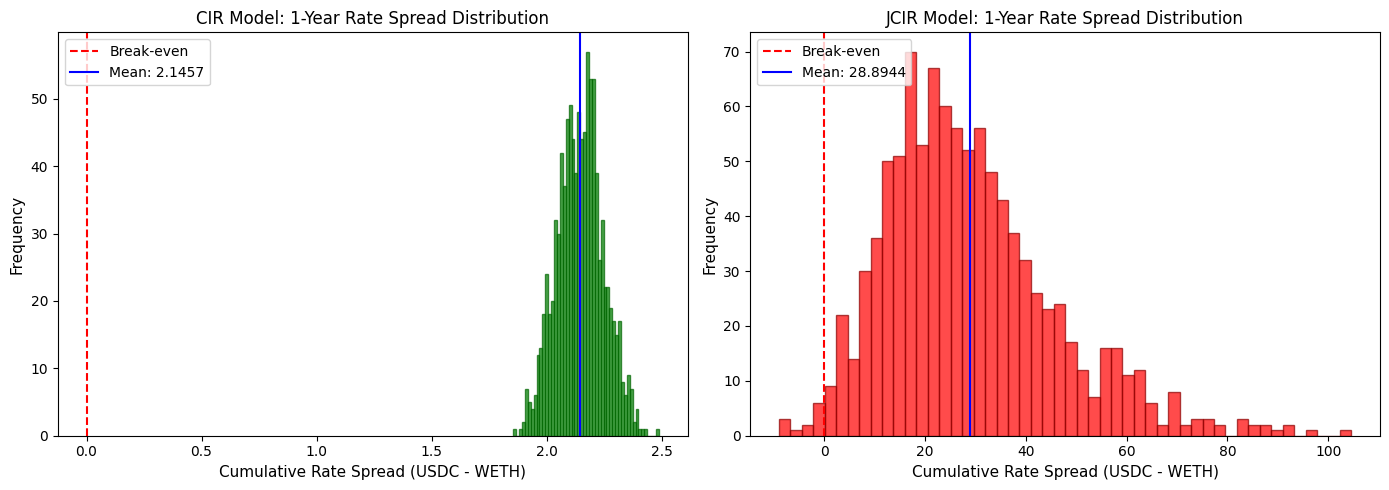


MONTE CARLO RESULTS SUMMARY


,Model,Mean Spread,Std Dev,Min,Max,5th Pct,95th Pct,P(Loss)
0,CIR,2.145696,0.100893,1.855317,2.488331,1.979872,2.314700,0.000
1,JCIR,28.894365,17.099562,-8.960075,104.595417,5.804728,61.247086,0.011



Probability of negative spread (loss) over 1 year:
  CIR:  0.00%
  JCIR: 1.10%


In [26]:
# Monte Carlo comparison: Distribution of final portfolio values under CIR vs JCIR

n_paths = 1000
n_steps = 365 * 24  # 1 year of hourly data
dt = 1.0 / (365.0 * 24)  # hourly

# Initial values (from data)
x0_usdc = usdc_ser.values[0]
x0_weth = weth_ser.values[0]

print("="*70)
print("MONTE CARLO SIMULATION: CIR vs JCIR")
print("="*70)
print(f"\nSimulating {n_paths} paths over 1 year (hourly steps)...")

# Storage for final cumulative rate differences
cir_final_spreads = np.zeros(n_paths)
jcir_final_spreads = np.zeros(n_paths)

for i in range(n_paths):
    seed = 1000 + i
    
    # CIR simulation
    cir_usdc_path = cir_model.simulate_cir_euler(
        x0_usdc, cir_usdc['kappa'], cir_usdc['theta'], cir_usdc['sigma'],
        dt, n_steps, rng=np.random.default_rng(seed)
    )
    cir_weth_path = cir_model.simulate_cir_euler(
        x0_weth, cir_weth['kappa'], cir_weth['theta'], cir_weth['sigma'],
        dt, n_steps, rng=np.random.default_rng(seed + n_paths)
    )
    
    # JCIR simulation
    jcir_usdc_path, _ = simulate_jcir_euler(
        x0_usdc, jcir_usdc['kappa'], jcir_usdc['theta'], jcir_usdc['sigma'],
        jcir_usdc['lambda_jump'], jcir_usdc['mu_jump'],
        dt, n_steps, rng=np.random.default_rng(seed)
    )
    jcir_weth_path, _ = simulate_jcir_euler(
        x0_weth, jcir_weth['kappa'], jcir_weth['theta'], jcir_weth['sigma'],
        jcir_weth['lambda_jump'], jcir_weth['mu_jump'],
        dt, n_steps, rng=np.random.default_rng(seed + n_paths)
    )
    
    # Cumulative rate spread (USDC earn - WETH pay) over the year
    # Integrated rate differential
    cir_final_spreads[i] = np.sum(cir_usdc_path - cir_weth_path) * dt
    jcir_final_spreads[i] = np.sum(jcir_usdc_path - jcir_weth_path) * dt

print("Simulation complete!")

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('none')

# CIR distribution
ax = axes[0]
ax.set_facecolor('none')
ax.hist(cir_final_spreads, bins=50, alpha=0.7, color='green', edgecolor='darkgreen')
ax.axvline(x=0, color='red', linestyle='--', lw=1.5, label='Break-even')
ax.axvline(x=np.mean(cir_final_spreads), color='blue', linestyle='-', lw=1.5, 
           label=f'Mean: {np.mean(cir_final_spreads):.4f}')
ax.set_xlabel('Cumulative Rate Spread (USDC - WETH)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('CIR Model: 1-Year Rate Spread Distribution', fontsize=12)
ax.legend(loc='upper left')
ax.grid(False)

# JCIR distribution
ax = axes[1]
ax.set_facecolor('none')
ax.hist(jcir_final_spreads, bins=50, alpha=0.7, color='red', edgecolor='darkred')
ax.axvline(x=0, color='red', linestyle='--', lw=1.5, label='Break-even')
ax.axvline(x=np.mean(jcir_final_spreads), color='blue', linestyle='-', lw=1.5,
           label=f'Mean: {np.mean(jcir_final_spreads):.4f}')
ax.set_xlabel('Cumulative Rate Spread (USDC - WETH)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('JCIR Model: 1-Year Rate Spread Distribution', fontsize=12)
ax.legend(loc='upper left')
ax.grid(False)

plt.tight_layout()

outp = repo_root / 'results' / 'plots' / 'mc_cir_vs_jcir_distribution.png'
plt.savefig(outp, bbox_inches='tight', transparent=True, dpi=150)
plt.show()

# Summary statistics
print("\n" + "="*70)
print("MONTE CARLO RESULTS SUMMARY")
print("="*70)

stats_comparison = {
    'Model': ['CIR', 'JCIR'],
    'Mean Spread': [np.mean(cir_final_spreads), np.mean(jcir_final_spreads)],
    'Std Dev': [np.std(cir_final_spreads), np.std(jcir_final_spreads)],
    'Min': [np.min(cir_final_spreads), np.min(jcir_final_spreads)],
    'Max': [np.max(cir_final_spreads), np.max(jcir_final_spreads)],
    '5th Pct': [np.percentile(cir_final_spreads, 5), np.percentile(jcir_final_spreads, 5)],
    '95th Pct': [np.percentile(cir_final_spreads, 95), np.percentile(jcir_final_spreads, 95)],
    'P(Loss)': [(cir_final_spreads < 0).mean(), (jcir_final_spreads < 0).mean()]
}

mc_df = pd.DataFrame(stats_comparison)
display(mc_df.round(6))

print(f"\nProbability of negative spread (loss) over 1 year:")
print(f"  CIR:  {(cir_final_spreads < 0).mean() * 100:.2f}%")
print(f"  JCIR: {(jcir_final_spreads < 0).mean() * 100:.2f}%")